In [1]:
#!pip install pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_excel("input/insurance.xlsx")
data.head()
#data.shape
#data.info()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


Check the feature correlations

<AxesSubplot:>

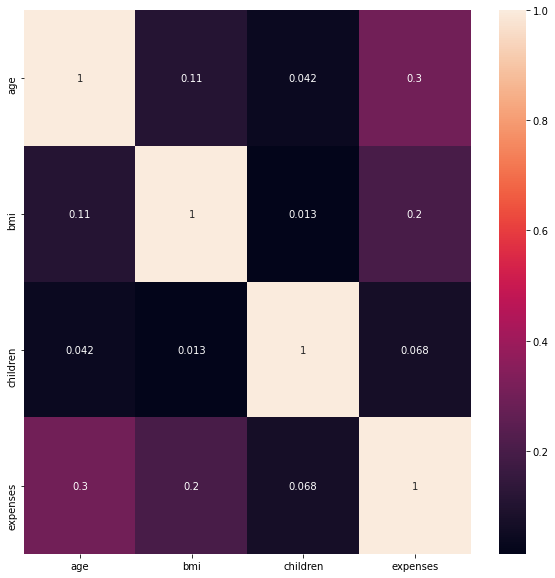

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
corr = data.corr()
sns.heatmap(corr , annot = True , ax=ax)

Label Encode Object Types

In [4]:
d_types = dict(data.dtypes)
for name , type_ in d_types.items():
    if str(type_) == 'object':
        print(f"<======== {name} ===========>")
        print(data[name].value_counts())

<======== sex ===========>
male      676
female    662
Name: sex, dtype: int64
<======== smoker ===========>
no     1064
yes     274
Name: smoker, dtype: int64
<======== region ===========>
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

for name , type_ in d_types.items():
    if str(type_) == 'object':
        Le = LabelEncoder()
        data[name] = Le.fit_transform(data[name])

In [6]:
# One hot Encoding 
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
part = onehotencoder.fit_transform(data['region'].values.reshape(-1,1)).toarray()
values = dict(data["region"].value_counts())
for e , (val , _) in enumerate(values.items()):
    data["region_" + str(val)] = part[:,e]

data = data.drop(["region"] , axis = 1)
data.head()
#data.info()

,age,sex,bmi,children,smoker,expenses,region_2,region_3,region_1,region_0
0,19,0,27.9,0,1,16884.92,0.0,0.0,0.0,1.0
1,18,1,33.8,1,0,1725.55,0.0,0.0,1.0,0.0
2,28,1,33.0,3,0,4449.46,0.0,0.0,1.0,0.0
3,33,1,22.7,0,0,21984.47,0.0,1.0,0.0,0.0
4,32,1,28.9,0,0,3866.86,0.0,1.0,0.0,0.0


In [7]:
Original_Y = data["expenses"].values.copy()
Original_Y

array([16884.92,  1725.55,  4449.46, ...,  1629.83,  2007.95, 29141.36])

Skewness in Column : Expenses  1.51587966289798


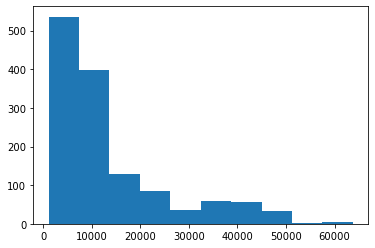

In [8]:
print("Skewness in Column : Expenses " , data["expenses"].skew())
plt.hist(data["expenses"])
plt.show()

Skewness in Column : Sqrt Expenses  0.7958625295340573


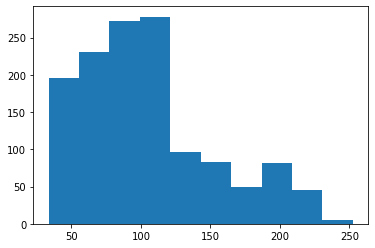

In [9]:
col_sqrt = np.sqrt(data["expenses"])
print("Skewness in Column : Sqrt Expenses " ,col_sqrt.skew())
plt.hist(col_sqrt)
plt.show()

Skewness in Column : boxcox Expenses  -0.008734062011873602


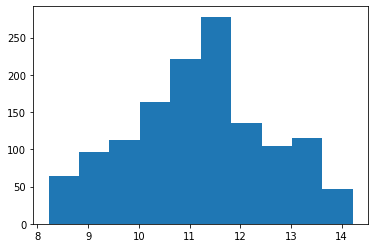

In [10]:
from scipy import stats 

col_cox , lam = stats.boxcox(data["expenses"])[0:2]
print("Skewness in Column : boxcox Expenses " ,pd.Series(col_cox).skew())
plt.hist(col_cox)
plt.show()

In [11]:
remaining_columns = list(data.columns)
remaining_columns.remove("expenses")

X = data[remaining_columns].values 
Y = data['expenses'].values

from sklearn.model_selection import train_test_split 
Xtrain , Xtest , Ytrain , Ytest = train_test_split(X , Y , test_size = 0.2 , random_state = 4)

from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
Xtrain = Scaler.fit_transform(Xtrain)
Xtest = Scaler.transform(Xtest)

Xtrain.shape , Xtest.shape

((1070, 9), (268, 9))

## standardized (mean should be 1)

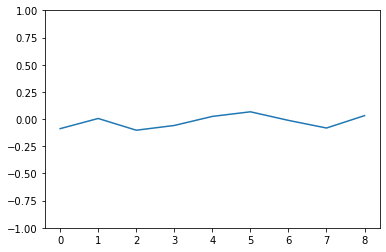

In [12]:
plt.ylim(-1,1)
means = []
for i in range(X.shape[1]):
    means.append(np.mean(Xtest[:,i]))
plt.plot(means , scaley=False)

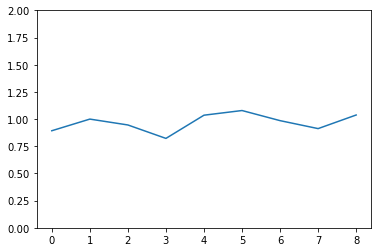

In [13]:
# Check variances 
plt.ylim(0,2)
vars = []
for i in range(X.shape[1]):
    vars.append(np.var(Xtest[:,i]))
plt.plot(vars)

## 普通線性回歸 LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(Xtrain , Ytrain)

LinearRegression()

In [15]:
# model.coef_ # 可查看係數
# model.intercept_ # 可查看截距值

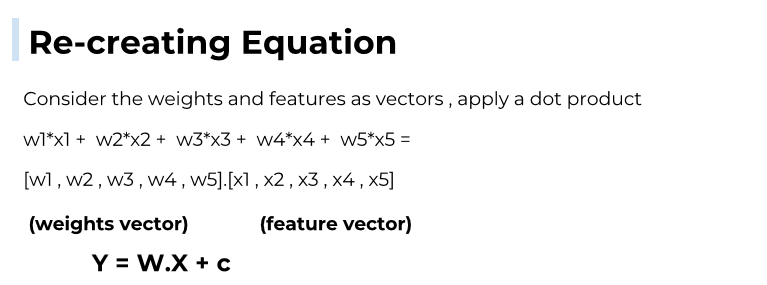

In [16]:
# Y = W.X + c
model.coef_.dot(Xtest[10,:]) + model.intercept_

3804.4723489048574

In [17]:
model.predict(Xtest[10,:].reshape(1,-1))

array([3804.4723489])

## Recursive Feature Elimination (RFECV) 遞歸特徵消除：特徵擷取的一種方法

通過交叉驗證來找到最優的特徵數量。如果減少特徵會造成性能損失，那麼將不會去除任何特徵。這個方法用以選取單模型特徵相當不錯，但是有兩個缺陷，一，計算量大。二，隨著學習器（評估器）的改變，最佳特徵組合也會改變，有些時候會造成不利影響。

- 對要訓練的機器學習算法進行建模
- 確定在一次迭代中要消除的特徵數量。
- 由於 RFECV 是遞歸迭代的，我們需要強行停止它。

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

#特徵選取
model = LinearRegression()
rfecv = RFECV(model , step = 1, min_features_to_select = 4 , n_jobs = -1) #每次去除特徵數  #最小特徵數
rfecv.fit(Xtrain , Ytrain)
model.fit(Xtrain , Ytrain)

LinearRegression()

In [19]:
selected_features = np.where(rfecv.support_)[0]
Xtrain = Xtrain[:,selected_features]
Xtest = Xtest[:,selected_features]
model.score(Xtest , Ytest) #測試與驗證

0.6929905313788508

In [20]:
# Y = W.X + c
model.coef_.dot(Xtest[10,:]) + model.intercept_

3804.4723489048574

In [21]:
model.predict(Xtest[10,:].reshape(1,-1))

array([3804.4723489])

In [22]:
# rfecv.support_  #保留排名
# rfecv.ranking_  #重要度排名
# model.coef_ # 可查看係數
# model.intercept_ # 可查看截距值

## Principal Component Analysis(PCA)  主成分分析：特徵擷取的一種方法

為降維(Dimension reduction)內特徵擷取(Feature extraction)的一種方法，降維就是希望資料的維度數減少，但整體的效能不會差異太多甚至會更好，降維（Dimensionality Reduction）是一種無監督學習，其最主要的目的是「化繁為簡」：將原本高維的數據（比方說 N 維）重新以一個相較低維的形式表達（比方說 K 維，且 K<N）。理想上只要該 K 維的表徵（representation）具有代表性，能夠抓住原來 N 維數據的大部分特性，我們就能在沒有損失什麼資訊的情況下，用更簡潔的方式呈現該組數據，進而對其本質有更深的理解。

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

pca = PCA(n_components = 7) #指定降維
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)
pca.explained_variance_ratio_.cumsum()

array([0.17706185, 0.32458986, 0.47200555, 0.59469268, 0.71153729,
       0.81727571, 0.91598789])

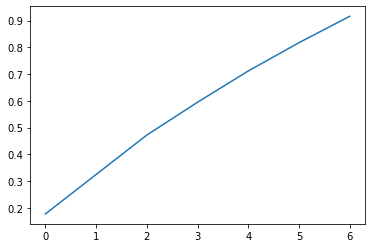

In [24]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [25]:
model = LinearRegression()
model.fit(Xtrain , Ytrain)
model.score(Xtest , Ytest) #測試與驗證

0.684456830461062

## 交叉驗證(Cross validation)
一般來說我們會將數據分為兩個部分，一部分用來訓練，一部分用來測試，交叉驗證是一種統計學上將樣本切割成多個小子集的做測試與訓練。交叉驗證主要分為以下幾類：

- k-folder cross-vailation
- kk folder cross-vaildation
- least-one-out cross-validation
- 10-fold corss validation

In [26]:
from sklearn.model_selection import KFold 
k_fold = KFold(n_splits=5) #訓練了模型5次
test_scores = []
for train_idx , test_idx in k_fold.split(X):
    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    model = LinearRegression()
    model.fit(Xtrain , Ytrain)

    test_scores.append(model.score(Xtest , Ytest))

 mean score of k folds :  0.7468792805399926


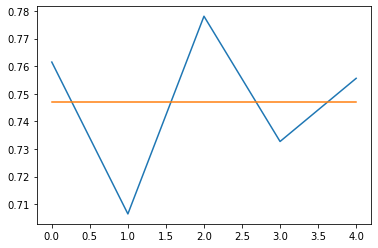

In [27]:
# 平均值決定了我們的全局分數，這意味著我們可以確信該模型的實時性能在這個數據集上就會出現。
# 0.76678 比我們之前的 0.7497 好

print(" mean score of k folds : " , np.mean(test_scores))
plt.plot(test_scores)
plt.plot([np.mean(test_scores)]*len(test_scores))
plt.show()

In [28]:
# Y = W.X + c
model.coef_.dot(Xtest[10,:]) + model.intercept_

5581.7294166449865

In [29]:
model.predict(Xtest[10,:].reshape(1,-1))

array([5581.72941664])

In [30]:
from scipy.special import inv_boxcox
transformed_data = inv_boxcox(Y , lam)
transformed_data[:10]

array([5.09752152e+65, 1.35235787e+43, 2.99003019e+52, 2.13849651e+68,
       1.22183436e+51, 6.32346313e+50, 3.83785604e+58, 2.27305037e+57,
       1.22157466e+56, 1.13993701e+71])

In [31]:
Original_Y[:10]

array([16884.92,  1725.55,  4449.46, 21984.47,  3866.86,  3756.62,
        8240.59,  7281.51,  6406.41, 28923.14])

## 指標定義

In [32]:
def rmse_score(y_test , y_pred):
    value = (1/len(y_test))*np.sum((y_test - y_pred)**2)
    return np.sqrt(value)

def r2_score(y_test , y_pred):
    ssr = (1/len(y_test))*np.sum((y_test - y_pred)**2)
    sst = (1/len(y_test))*np.sum((y_test - np.mean(y_test))**2)
    return (1 - (ssr/sst))

def mae(y_test , y_pred):
    return (1/len(y_test))*np.sum(np.abs(y_test - y_pred))

def adj_r2_score(y_test , y_pred , n_features):
    numerator = (1-r2_score(y_test , y_pred))*(len(y_test) - 1)
    denominator = len(y_test) - n_features - 1
    return 1 - (numerator/denominator)

 Average RMSE  6072.199631201661


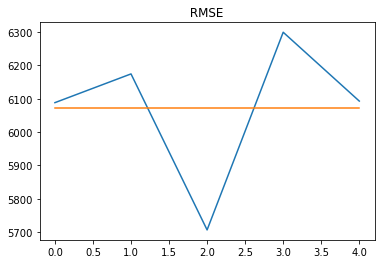

 Average MAE  4197.447162250032


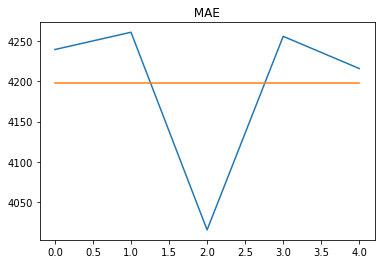

 Average R square  0.7468792805399929


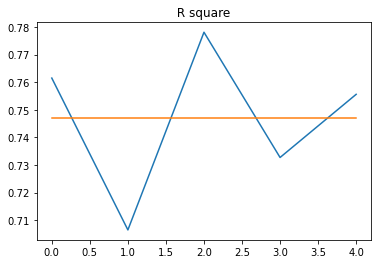

 Average Adj R square  0.7380355977609749


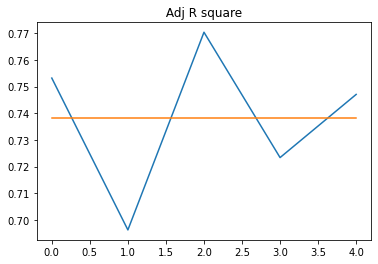

In [33]:
k_fold = KFold(n_splits=5)

# Plotting Root mean squared error 
rmse_scores = []
r2_scores = []
mae_scores = []
r2_adj_scores = []

for train_idx , test_idx in k_fold.split(X):
    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    model = LinearRegression()
    model.fit(Xtrain , Ytrain)

    Ypred = model.predict(Xtest)
    rmse_scores.append(rmse_score(Ytest , Ypred))
    r2_scores.append(r2_score(Ytest , Ypred))
    mae_scores.append(mae(Ytest , Ypred))
    r2_adj_scores.append(adj_r2_score(Ytest , Ypred , Xtest.shape[1]))

print(" Average RMSE " , np.mean(rmse_scores))
plt.plot(rmse_scores)
plt.plot([np.mean(rmse_scores)]*len(rmse_scores))
plt.title(" RMSE ")
plt.show()

print(" Average MAE " , np.mean(mae_scores))
plt.plot(mae_scores)
plt.plot([np.mean(mae_scores)]*len(mae_scores))
plt.title(" MAE ")
plt.show()

print(" Average R square " , np.mean(r2_scores))
plt.plot(r2_scores)
plt.plot([np.mean(r2_scores)]*len(r2_scores))
plt.title(" R square ")
plt.show()

print(" Average Adj R square " , np.mean(r2_adj_scores))
plt.plot(r2_adj_scores)
plt.plot([np.mean(r2_adj_scores)]*len(r2_adj_scores))
plt.title(" Adj R square ")
plt.show()

In [34]:
from scipy.special import inv_boxcox

Real_data = inv_boxcox(Y , lam)

In [35]:
Real_data[:10]

array([5.09752152e+65, 1.35235787e+43, 2.99003019e+52, 2.13849651e+68,
       1.22183436e+51, 6.32346313e+50, 3.83785604e+58, 2.27305037e+57,
       1.22157466e+56, 1.13993701e+71])

In [36]:
Original_Y[:10]

array([16884.92,  1725.55,  4449.46, 21984.47,  3866.86,  3756.62,
        8240.59,  7281.51,  6406.41, 28923.14])